Import needed libraries

In [3]:
import cv2
import torch
from Encoders import TimeToFirstSpikeEncoding, GaussianEncoding, PoissonEncoding
from matplotlib import pyplot as plt
from pymonntorch import *
import numpy as np
from timeRes import TimeResolution
from current import *
from lif import LIF, InputPattern
from synapse import *
from connections import Connections
from learning import *

In [4]:
# read an image and convert it to torch tensor
def image_to_vec(address, size=(10, 10)):
    img = cv2.imread(address)
    img = cv2.resize(img, (size[0], size[1]))
    img = torch.from_numpy(img)
    img = img.sum(2)//3

    return img


def show_image(img):
    plt.imshow(img, cmap='gray')  
    plt.show()


In [5]:
def raster_plot(spikes, fsize=(5,5)):
    
    plt.figure(figsize=fsize)
    plt.xlim(0, len(spikes))
    s_spikes = torch.nonzero(spikes)
    plt.scatter(s_spikes[:,0], s_spikes[:,1], s=2, c='darkviolet')
    
        
    plt.xlabel("Time")
    plt.ylabel("Neurons")
    plt.show()

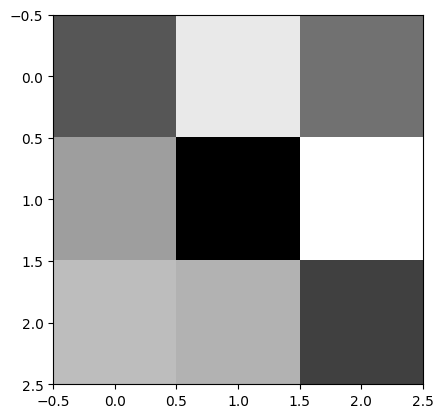

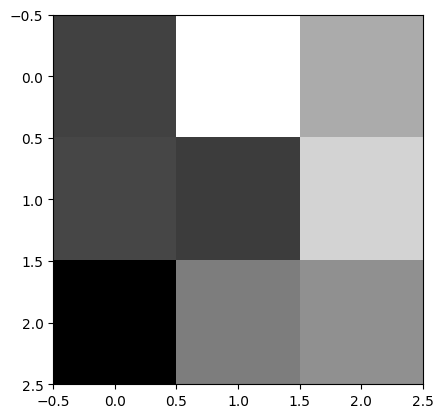

In [6]:
img1 = image_to_vec('images/barb.tif', (3, 3))
show_image(img1)
# img2 = image_to_vec('images/circles.tif', (3, 3))
# show_image(img2)
img3 = image_to_vec('images/lena1.tif', (3, 3))
show_image(img3)
# img4 = image_to_vec('images/library.tif', (50, 50))
# show_image(img4)


### Time To First Spike Encoding

In [18]:
ttfs1 = TimeToFirstSpikeEncoding(img1, 200)
ttfs2 = TimeToFirstSpikeEncoding(img2, 200)
ttfs3 = TimeToFirstSpikeEncoding(img3, 200)
ttfs4 = TimeToFirstSpikeEncoding(img4, 200)

ttfs_spikes1 = ttfs1.encode()
ttfs_spikes2 = ttfs2.encode()
ttfs_spikes3 = ttfs3.encode()
ttfs_spikes4 = ttfs4.encode()

raster_plot(ttfs_spikes1)
raster_plot(ttfs_spikes2)
raster_plot(ttfs_spikes3)
raster_plot(ttfs_spikes4)

NameError: name 'img2' is not defined

### Gaussian Encoding

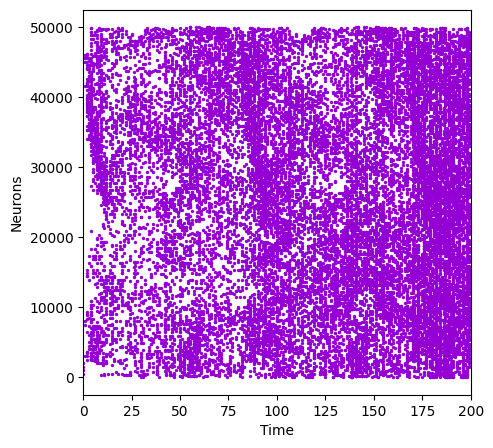

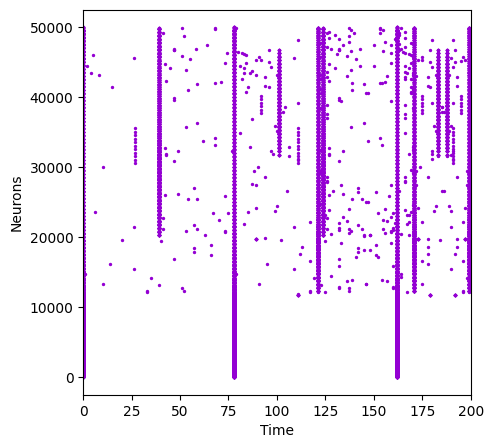

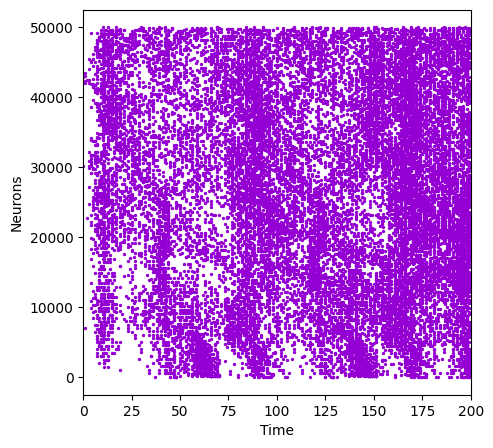

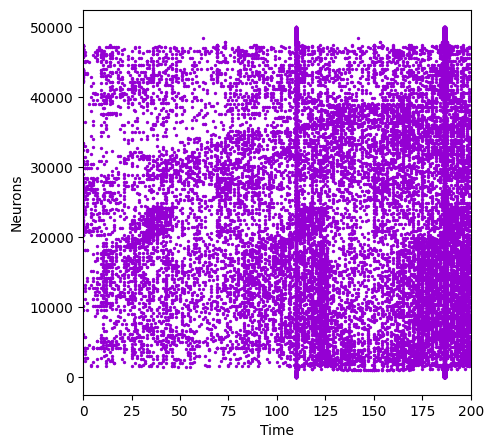

In [ ]:
ge1 = GaussianEncoding(img1, 200, 5)
ge2 = GaussianEncoding(img2, 200, 5)
ge3 = GaussianEncoding(img3, 200, 5)
ge4 = GaussianEncoding(img4, 200, 5)

ge_spikes1 = ge1.encode()
ge_spikes2 = ge2.encode()
ge_spikes3 = ge3.encode()
ge_spikes4 = ge4.encode()

raster_plot(ge_spikes1)
raster_plot(ge_spikes2)
raster_plot(ge_spikes3)
raster_plot(ge_spikes4)

### Poisson Encoding

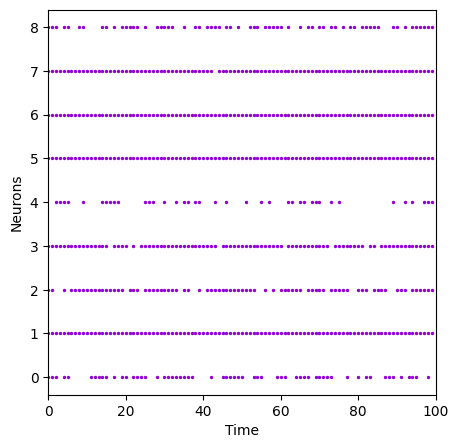

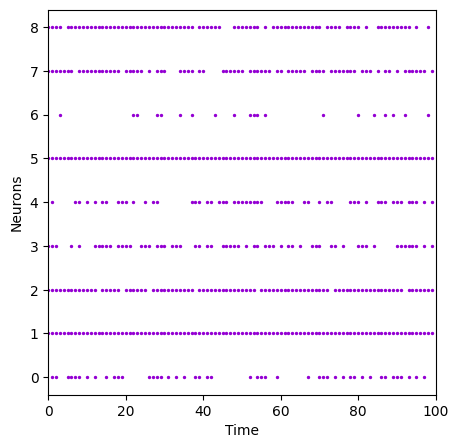

In [7]:
pe1 = PoissonEncoding(img1, 100, 200)
# pe2 = PoissonEncoding(img2, 100, 100)
pe3 = PoissonEncoding(img3, 100, 200)
# pe4 = PoissonEncoding(img4, 200)

pe_spikes1 = pe1.encode()
# pe_spikes2 = pe2.encode()
pe_spikes3 = pe3.encode()
# pe_spikes4 = pe4.encode()

raster_plot(pe_spikes1)
# raster_plot(pe_spikes2)
raster_plot(pe_spikes3)
# raster_plot(pe_spikes4)


In [8]:
def fill_pattern(pattern, n_free, is_right=True):
    pattern = pattern.transpose(-2, 1)
    shape = pattern.shape
    new_pattern = torch.zeros(shape[0]+n_free, shape[1])
    if is_right:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i][j] = pattern[i][j] 
    else:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i+n_free][j] = pattern[i][j]

    return new_pattern


In [9]:
def noisy_pattern(pattern1, n=300):
    indexesi = [random.randint(0, 99) for _ in range(n)]
    indexesj = [random.randint(0, 8) for _ in range(n)]

    k = 0
    for i in range(n):
        if pattern1[indexesi[k]][indexesj[k]]:
            pattern1[indexesi[k]][indexesj[k]] = False
        else:
            pattern1[indexesi[k]][indexesj[k]] = True
        k += 1

    return pattern1
            

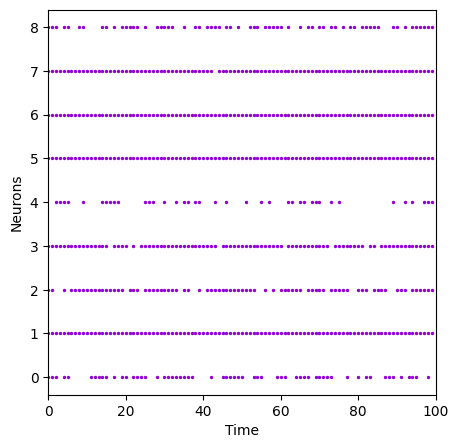

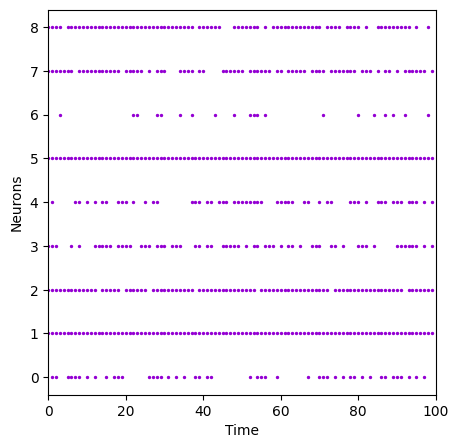

In [11]:
pattern1 = fill_pattern(pe_spikes1, 0)
pattern2 = fill_pattern(pe_spikes3, 0, False)
pattern1 = pattern1.transpose(-2, 1)
pattern2 = pattern2.transpose(-2, 1)
raster_plot(pattern1)
raster_plot(pattern2)
# p1 = pattern1.copy()
# p2 = pattern2.copy()
# pattern1 = noisy_pattern(pattern1)
# pattern2 = noisy_pattern(pattern2)
# raster_plot(pattern1)
# raster_plot(pattern2)

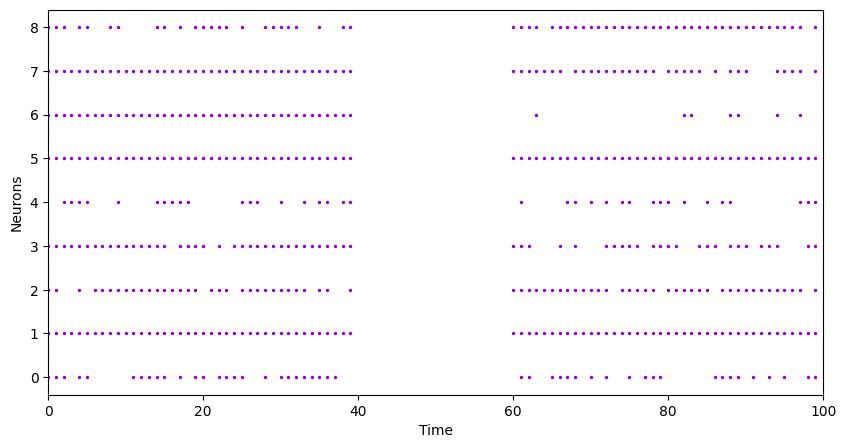

In [12]:
patt = torch.zeros(100, 9)
for i in range(100):
    for j in range(pattern2.shape[1]):
        if i < 40:
            patt[i][j] = pattern1[i][j]
        elif i >= 40 and i < 60:
            patt[i][j] = 0
        else:
            patt[i][j] = pattern2[i-60][j]
raster_plot(patt, fsize=(10, 5))

In [86]:

net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    9,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=45, sleep=10, tau_t=1.2),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    2,
    net=net,
    behavior={
        2: ConstantCurrent(value=20),
        5: InpSyn(),
        7: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-35,
            R=5,
            N=2,
        ),
        9: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: STDP(lr=[10,15],wd=15, wmin=10, wmax=60),
                    5: Connections(def_val=30, type="full"),    
                    11: Recorder(variables=["W"], tag="layers weights"),  
                })


In [18]:
net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    100,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=200, sleep=50),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    3,
    net=net,
    behavior={
        2: ConstantCurrent(value=10),
        5: InpSyn(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-35,
            R=5,
            N=2,
        ),
        9: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: STDP(),
                    5: Connections(def_val=20, type="full"),    
                    11: Recorder(variables=["W"], tag="layers weights"),  
                })


In [87]:
net.initialize()
net.simulate_iterations(100)

Network['Network_1', 'Network'](Neurons: tensor(11)|2 groups, Synapses: tensor(18)|1 groups){1:TimeResolution()}
NeuronGroup['inp_NG1', 'NeuronGroup', 'ng'](9){7:InputPattern(pattern=tensor([[1., 1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 0., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1.

438.2789134979248

Text(0, 0.5, 'sosine similarity')

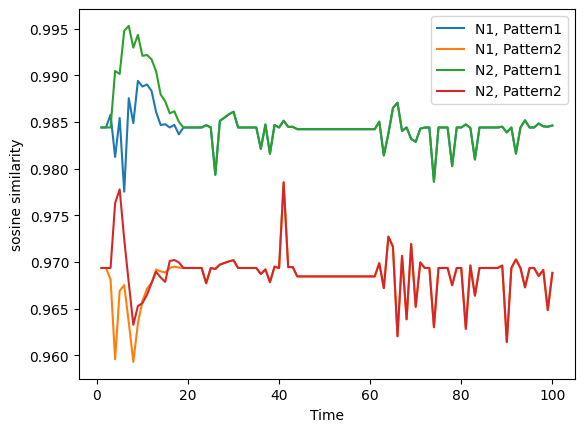

In [52]:
p1s, p2s = [], []
for i in range(pattern1.shape[1]):
    s1, s2 = 0, 0
    for j in range(40):
        if pattern1[j][i] == 1:
            s1 += 1
        if pattern2[j][i] == 1:
            s2 += 1
    p1s.append(s1)
    p2s.append(s2)


net1 = net["W", 0]
res1 = []
res2 = []
res3 = []
res4 = []
for i in range(net1.shape[0]):
    column1 = []  # First column
    column2 = []  # First column
    for j in range(net1.shape[1]):
        column1.append(net1[i][j][0].item())
        column2.append(net1[i][j][1].item())

    dot_product1 = np.dot(column1, p1s)
    dot_product2 = np.dot(column1, p2s)
    dot_product3 = np.dot(column2, p1s)
    dot_product4 = np.dot(column2, p2s)

    magnitude1 = np.linalg.norm(column1)
    magnitudes1 = np.linalg.norm(p1s)
    magnitude2 = np.linalg.norm(column2)
    magnitudes2 = np.linalg.norm(p2s)

    # Calculate cosine similarity
    cosine_similarity1 = dot_product1 / (magnitude1 * magnitudes1)
    cosine_similarity2 = dot_product2 / (magnitude1 * magnitudes2)
    cosine_similarity3 = dot_product3 / (magnitude2 * magnitudes1)
    cosine_similarity4 = dot_product4 / (magnitude2 * magnitudes2)
    
    res1.append(cosine_similarity1)
    res2.append(cosine_similarity2)
    res3.append(cosine_similarity3)
    res4.append(cosine_similarity4)

time = [i for i in range(1, 101)]
plt.plot(time, res1, label="N1, Pattern1")
plt.plot(time, res2, label="N1, Pattern2")
plt.plot(time, res3, label="N2, Pattern1")
plt.plot(time, res4, label="N2, Pattern2")
plt.legend()
plt.xlabel("Time")
plt.ylabel("sosine similarity")
# for i in range(net1.shape[0]):
#     column1.append(net1[i][0].item())
#     column2.append(net1[i][1].item())
# # column2 = matrix[:, 1]  # Second column
# print(column1, column2)
# # Calculate dot product
# dot_product = np.dot(column1, column2)
# print(dot_product)
# # Calculate magnitudes
# magnitude1 = np.linalg.norm(column1)
# magnitude2 = np.linalg.norm(column2)
# print(magnitude1, magnitude2)
# # Calculate cosine similarity
# cosine_similarity = dot_product / (magnitude1 * magnitude2)
# print(cosine_similarity)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100


Text(0, 0.5, 'weight')

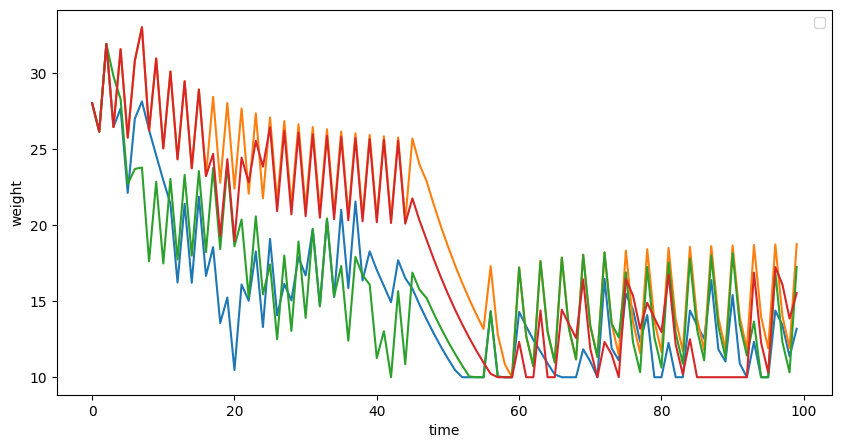

In [88]:
# print(net["W", 0][-1])
vars1 = []
vars2 = []
time = [i for i in range(100)]
for i in range(9):
    x = []
    y = []
    for j in range(100):
        x.append(net["W", 0][j][i][0])
        y.append(net["W", 0][j][i][1])
    vars1.append(x)
    vars2.append(y)

print(len(vars1[0]))
plt.figure(figsize=(10, 5))
for i in range(4):
    
    # plt.plot(time, vars2[i], label=f"w{i}")
    plt.plot(time, vars1[i])
    # plt.plot(time, vars2[i])
    # sum1 = 0
    # sum2 = 0
    # for j in range(18):
    #     sum1 += net["W", 0][i][j][1]
    #     sum2 += net["W", 0][i][j][0]
    # vars1.append(sum1/2500)
    # vars2.append(sum2/2500)
plt.legend()
plt.xlabel("time")
plt.ylabel("weight")
# plt.plot(time, vars1)
# plt.plot(time, vars2)
# # plt.plot(vars2, label="exc2")
# # plt.plot(vars3, label="inh")
# plt.xlabel("time")
# plt.ylabel("v")
# plt.legend()
# plt.show()

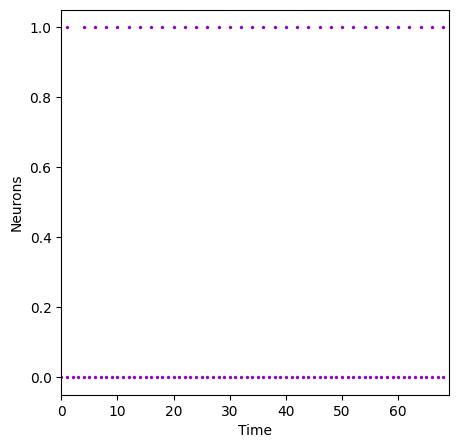

In [16]:
raster_plot(net["spike", 0])